In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

def add_noise(imgs):
    noise = torch.randn_like(imgs) * 0.5
    noisy_imgs = imgs + noise
    return torch.clip(noisy_imgs, 0., 1.)

class NoisyMNIST(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, target = self.mnist_dataset[idx]
        noisy_img = add_noise(img)
        return img, noisy_img, target
    
train_noisy_dataset = NoisyMNIST(train_dataset)
test_noisy_dataset = NoisyMNIST(test_dataset)

batch_size = 1024
train_loader = DataLoader(dataset=train_noisy_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_noisy_dataset, batch_size=batch_size, shuffle=False)

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

    def forward(self, z):
        return self.decoder(z)

class DCCAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(DCCAE, self).__init__()
        self.encoder1 = Encoder(input_dim, latent_dim)
        self.encoder2 = Encoder(input_dim, latent_dim)
        
        self.decoder1 = Decoder(latent_dim, input_dim)
        self.decoder2 = Decoder(latent_dim, input_dim)

    def forward(self, x1, x2):
        z1 = self.encoder1(x1)
        z2 = self.encoder2(x2)
        x1_recon = self.decoder1(z1)
        x2_recon = self.decoder2(z2)
        return z1, z2, x1_recon, x2_recon

def reconstruction_loss(x, x_recon):
    return nn.functional.mse_loss(x_recon, x)

def cca_loss(z1, z2, outdim_size, r1=1e-3, r2=1e-3, eps=1e-9):
    z1, z2 = z1.t(), z2.t()

    o1 = o2 = z1.size(0)
    m = z1.size(1)

    z1bar = z1 - z1.mean(dim=1, keepdim=True)
    z2bar = z2 - z2.mean(dim=1, keepdim=True)

    SigmaHat12 = (1 / (m - 1)) * torch.matmul(z1bar, z2bar.t())
    SigmaHat11 = (1 / (m - 1)) * torch.matmul(z1bar, z1bar.t()) + r1 * torch.eye(o1, device=z1.device)
    SigmaHat22 = (1 / (m - 1)) * torch.matmul(z2bar, z2bar.t()) + r2 * torch.eye(o2, device=z2.device)

    D1, V1 = torch.linalg.eigh(SigmaHat11, UPLO='L')
    D2, V2 = torch.linalg.eigh(SigmaHat22, UPLO='L')

    posInd1 = torch.gt(D1, eps).nonzero(as_tuple=True)[0]
    D1 = D1[posInd1]
    V1 = V1[:, posInd1]
    posInd2 = torch.gt(D2, eps).nonzero(as_tuple=True)[0]
    D2 = D2[posInd2]
    V2 = V2[:, posInd2]

    SigmaHat11RootInv = torch.matmul(torch.matmul(V1, torch.diag(D1 ** -0.5)), V1.t())
    SigmaHat22RootInv = torch.matmul(torch.matmul(V2, torch.diag(D2 ** -0.5)), V2.t())

    Tval = torch.matmul(torch.matmul(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)

    trace_TT = torch.matmul(Tval.t(), Tval)
    trace_TT = torch.add(trace_TT, torch.eye(trace_TT.shape[0], device=z1.device) * r1)
    U, _ = torch.linalg.eigh(trace_TT, UPLO='L')
    U = torch.where(U > eps, U, torch.ones_like(U) * eps)
    U = U.topk(outdim_size)[0]
    corr = torch.sum(torch.sqrt(U))

    return -corr

In [20]:
input_dim = 28 * 28
latent_dim = 128

dccae = DCCAE(input_dim, latent_dim).to(device)

optimizer = optim.Adam(dccae.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 50
losses = []

dccae.train()
for epoch in range(epochs):
    total_loss = 0
    for (x1, x2, _) in train_loader:
        x1 = x1.view(-1, 28*28).to(device)
        x2 = x2.view(-1, 28*28).to(device)
        
        optimizer.zero_grad()
        z1, z2, x1_recon, x2_recon = dccae(x1, x2)
        recon_loss1 = reconstruction_loss(x1, x1_recon)
        recon_loss2 = reconstruction_loss(x2, x2_recon)
        cca_loss_val = cca_loss(z1, z2, latent_dim)
        loss = cca_loss_val + (recon_loss1 + recon_loss2) * 0.001
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")

Epoch 1/50, Avg Loss: -102.2714
Epoch 2/50, Avg Loss: -120.9634
Epoch 3/50, Avg Loss: -122.7073
Epoch 4/50, Avg Loss: -123.5211
Epoch 5/50, Avg Loss: -124.0042
Epoch 6/50, Avg Loss: -124.3337
Epoch 7/50, Avg Loss: -124.5885
Epoch 8/50, Avg Loss: -124.8018
Epoch 9/50, Avg Loss: -124.9672
Epoch 10/50, Avg Loss: -125.1036
Epoch 11/50, Avg Loss: -125.2156
Epoch 12/50, Avg Loss: -125.3102
Epoch 13/50, Avg Loss: -125.3969
Epoch 14/50, Avg Loss: -125.4774
Epoch 15/50, Avg Loss: -125.5413
Epoch 16/50, Avg Loss: -125.6083
Epoch 17/50, Avg Loss: -125.6581
Epoch 18/50, Avg Loss: -125.7133
Epoch 19/50, Avg Loss: -125.7682
Epoch 20/50, Avg Loss: -125.8115
Epoch 21/50, Avg Loss: -125.8524
Epoch 22/50, Avg Loss: -125.8865
Epoch 23/50, Avg Loss: -125.9185
Epoch 24/50, Avg Loss: -125.9493
Epoch 25/50, Avg Loss: -125.9980
Epoch 26/50, Avg Loss: -126.0082
Epoch 27/50, Avg Loss: -126.0261
Epoch 28/50, Avg Loss: -126.0597
Epoch 29/50, Avg Loss: -126.0974
Epoch 30/50, Avg Loss: -126.1055
Epoch 31/50, Avg Lo

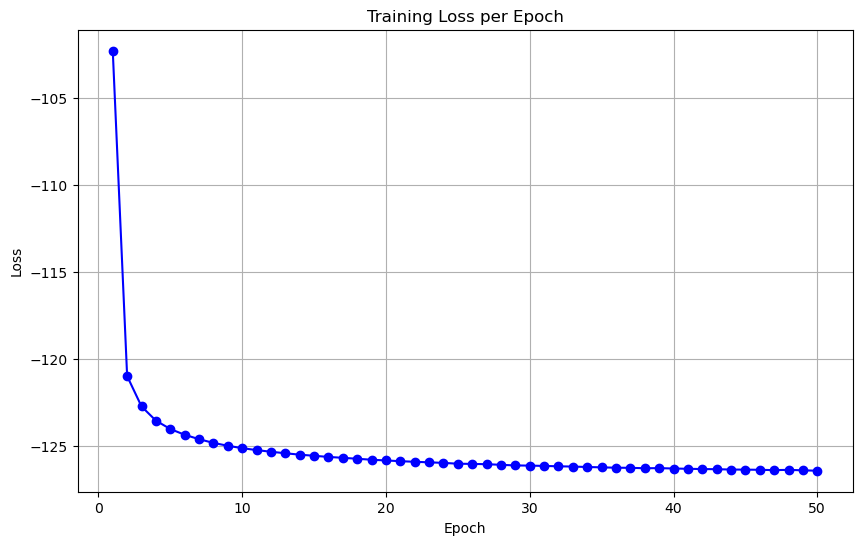

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [23]:
dccae.eval()
z1_list, z2_list, x1_list, x2_list, labels_list = [], [], [], [], []
with torch.no_grad():
    for (x1, x2, labels) in test_loader:
        x1 = x1.view(-1, 28*28).to(device)
        x2 = x2.view(-1, 28*28).to(device)
        
        z1, z2, _, _ = dccae(x1, x2)
        z1_list.append(z1.cpu().numpy())
        z2_list.append(z2.cpu().numpy())
        x1_list.append(x1.cpu().numpy())
        x2_list.append(x2.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

z1_all = np.concatenate(z1_list, axis=0)
z2_all = np.concatenate(z2_list, axis=0)
x1_all = np.concatenate(x1_list, axis=0)
x2_all = np.concatenate(x2_list, axis=0)
labels_all = np.concatenate(labels_list, axis=0)

In [33]:
def plot_concatenated_latent_space(X, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], s=4, c=labels, cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.title(title)
    plt.show()

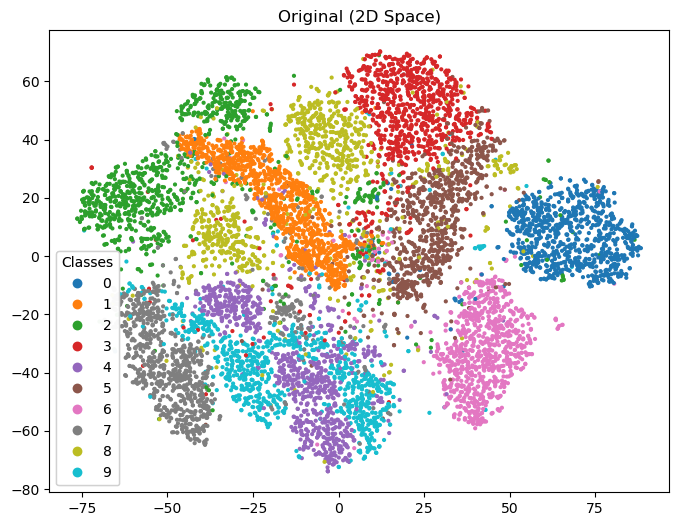

In [34]:
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x2_all)

plot_concatenated_latent_space(x_tsne, labels_all, "Original (2D Space)")

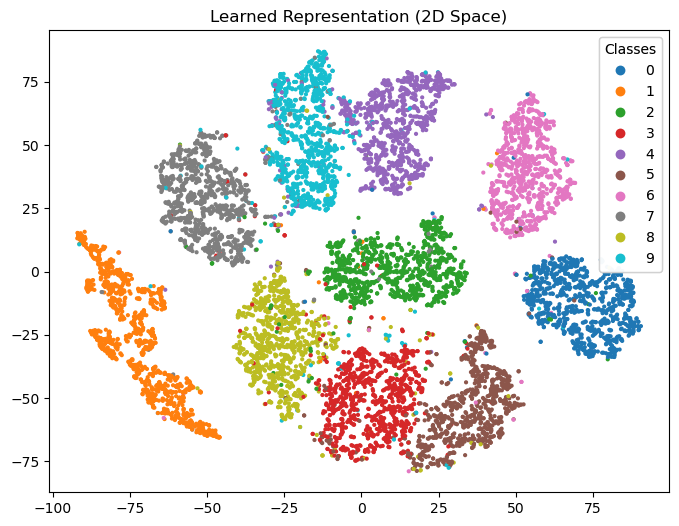

In [35]:
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z2_all)

plot_concatenated_latent_space(z_tsne, labels_all, "Learned Representation (2D Space)")